# $\textit{Predicción lineal}$
$\textit{By Agustín Luís Gullino - Gonzalo Ezequiel Linares}$

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import helper as hp
import importlib
importlib.reload(hp)

fs = 16000  # Frecuencia de muestreo

In [75]:
fs, signal, path = hp.getRecordedSignals()
x_a = np.insert(signal["a"][:-1], 0, 0) # Creamos la señal retrasada 1 tap
x_sh = np.insert(signal["sh"][:-1], 0, 0) # Creamos la señal retrasada 1 tap

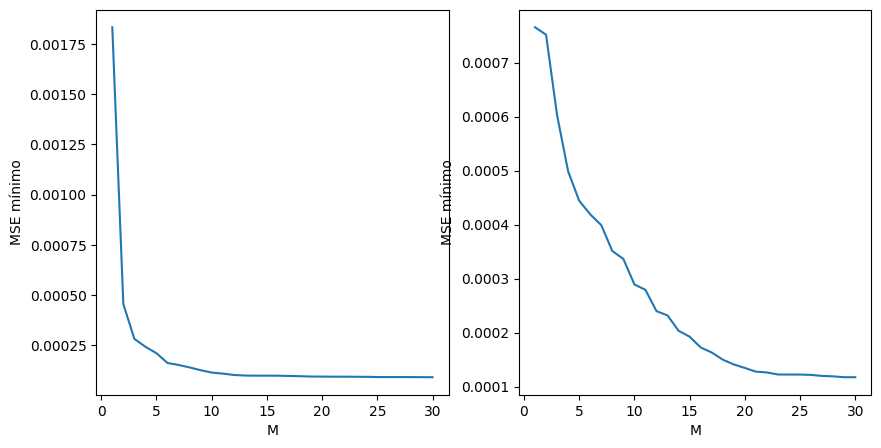

In [84]:
Ms = np.linspace(1, 30, 30, dtype=int)
jos_a = np.zeros(len(Ms))
jos_sh = np.zeros(len(Ms))
a_a = np.zeros((len(Ms), len(Ms)+1))
a_sh = np.zeros((len(Ms), len(Ms)+1))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i, M in enumerate(Ms):
    wo, jo, NMSE = hp.get_optimal_params(x_a, signal["a"], M)
    jos_a[i] = jo
    a_a[i][:i+2] = np.insert(wo, 0, 1) 

    wo, jo, NMSE = hp.get_optimal_params(x_sh, signal["sh"], M)
    jos_sh[i] = jo
    a_sh[i][:i+2] = np.insert(wo, 0, 1) 

axs[0].set_xlabel('M')
axs[0].set_ylabel('MSE mínimo')
axs[0].plot(Ms, jos_a)

axs[1].set_xlabel('M')
axs[1].set_ylabel('MSE mínimo')
axs[1].plot(Ms, jos_sh)

In [94]:
e_foa = np.convolve(a_a[28],signal["a"])

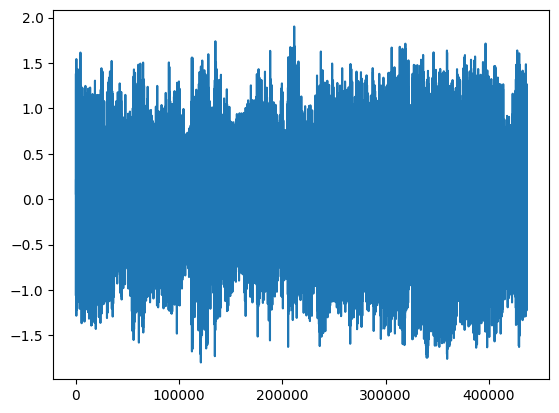

In [95]:
plt.figure()
plt.plot(e_foa)